# Imports

In [11]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
# from sklearn.preprocessing import OneHotEncoder
# from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
# import seaborn as sns
%matplotlib inline

# Loading data

In [21]:
# Load each user's data and merge all of the data together

dfs = []
for i in range(1, 23):
    if i != 21: # jump user 21 because he has no saliva data
        # Extract sensor data
        dir_ = "data/24H/user_" + str(i) + "/Actigraph.csv" # Create path
        df = pd.read_csv(dir_) # Load data

        # Extract stress data
        dir_ = "data/24H/user_" + str(i) + "/questionnaire.csv" # Create path
        df_stress = pd.read_csv(dir_) # Load data

        # Extract saliva data
        dir_ = "data/24H/user_" + str(i) + "/saliva.csv" # Create path
        df_saliva = pd.read_csv(dir_) # Load data

        # Append columns to initial dataframe
        user_col = (np.ones(len(df)) * i).astype(int)
        stress_col = (np.ones(len(df)) * df_stress['Daily_stress'][0]).astype(int)
        cortisol_before_sleep_col = (np.ones(len(df)) * df_saliva['Cortisol NORM'][0])

        df['user_id'] = user_col
        df['stress_level'] = stress_col
        df['cortisol_before_sleep'] = cortisol_before_sleep_col
        
        df = df[df['HR'] >= df['HR'].median()]
        dfs.append(df)
    
# Concatenate all of them together
df_all = pd.concat(dfs)

# Drop the first column, which is useless
df_all = df_all.drop('Unnamed: 0', axis=1)

In [23]:
df_all.head(10)

,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,time,user_id,stress_level,cortisol_before_sleep
4,34,14,63,1,154.0,0,1,0,0,72.95,1,10:10:26,1,23,0.034137
5,101,10,90,0,161.0,0,1,0,0,135.65,1,10:10:27,1,23,0.034137
6,17,18,49,0,177.0,0,1,0,0,54.90,1,10:10:28,1,23,0.034137
7,0,34,23,0,177.0,0,1,0,0,41.05,1,10:10:29,1,23,0.034137
8,12,50,13,1,177.0,0,1,0,0,53.04,1,10:10:30,1,23,0.034137
9,32,38,36,0,177.0,0,1,0,0,61.35,1,10:10:31,1,23,0.034137
10,63,72,156,1,177.0,0,1,0,0,183.00,1,10:10:32,1,23,0.034137
16,0,0,0,0,133.0,0,0,1,0,0.00,1,10:11:51,1,23,0.034137
17,39,10,0,1,132.0,0,1,0,0,40.26,1,10:11:52,1,23,0.034137
18,67,0,62,0,132.0,0,1,0,0,91.29,1,10:11:53,1,23,0.034137


# Handling data to extract relevant features
In this part we extract only the features we will be using :
* Heart rate : main measurement used to detect stress
* Vector Magnitude : accelerometer data to detect movement. This will allow us to ignore any heartbeat increases linked to movement, so linked to sports usually.
* stress_level : will allow us to label any measurements with the corresponding stress levels for the person
* cortisol_before_sleep : will allow us to give more robustness to the stress levels later on

We will also look into the variations of the heart rate and accelerometer, because that is where we could see the stress levels raise. The variation of accelerometer allows us to detect when the person is performing sports eventually.

In [24]:
# Focus on interesting data
df_analysis = df_all[['HR', 'Vector Magnitude', 'stress_level', 'cortisol_before_sleep', 'user_id']].copy()

In [25]:
HR_derivatives = []
accel_derivatives = []

for i in range(1, 23):
    if i != 21:
        # Extract HR data only
        df_HR = (df_analysis[df_analysis['user_id'] == i]['HR']).to_numpy()
        
        # Extract accelerometre data only
        df_accel = (df_analysis[df_analysis['user_id'] == i]['Vector Magnitude']).to_numpy()

        # Create array for storing derivative for each second for a user
        der_HR = [0] # Init array with 0 change 
        der_accel = [0]
        
        # Iterate on whole HR data for user
        for j in range(1, len(df_HR)):
            diff_HR = df_HR[j] - df_HR[j-1] # Differentiate HR 
            diff_accel = df_accel[j] - df_accel[j-1] # Differentiate accel
            
            # Append to user array
            der_HR.append(diff_HR) 
            der_accel.append(diff_accel)
        
        # Append to global (all users) array
        HR_derivatives.extend(der_HR)
        accel_derivatives.extend(der_accel)

# Add columns to Dataframe
df_analysis['HR_derivative'] = HR_derivatives
df_analysis['accel_derivative'] = accel_derivatives

In [26]:
df_analysis.head(20)

,HR,Vector Magnitude,stress_level,cortisol_before_sleep,user_id,HR_derivative,accel_derivative
4,154.0,72.95,23,0.034137,1,0.0,0.00
5,161.0,135.65,23,0.034137,1,7.0,62.70
6,177.0,54.90,23,0.034137,1,16.0,-80.75
7,177.0,41.05,23,0.034137,1,0.0,-13.85
8,177.0,53.04,23,0.034137,1,0.0,11.99
9,177.0,61.35,23,0.034137,1,0.0,8.31
10,177.0,183.00,23,0.034137,1,0.0,121.65
16,133.0,0.00,23,0.034137,1,-44.0,-183.00
17,132.0,40.26,23,0.034137,1,-1.0,40.26
18,132.0,91.29,23,0.034137,1,0.0,51.03


# Regression

In [27]:
feature_cols = ['HR', 'Vector Magnitude', 'HR_derivative', 'accel_derivative', 'cortisol_before_sleep']
X = df_analysis[feature_cols]
y = df_analysis.stress_level

In [28]:
lin_reg = LinearRegression()  # create the model
lin_reg.fit(X, y)  # train it

LinearRegression()

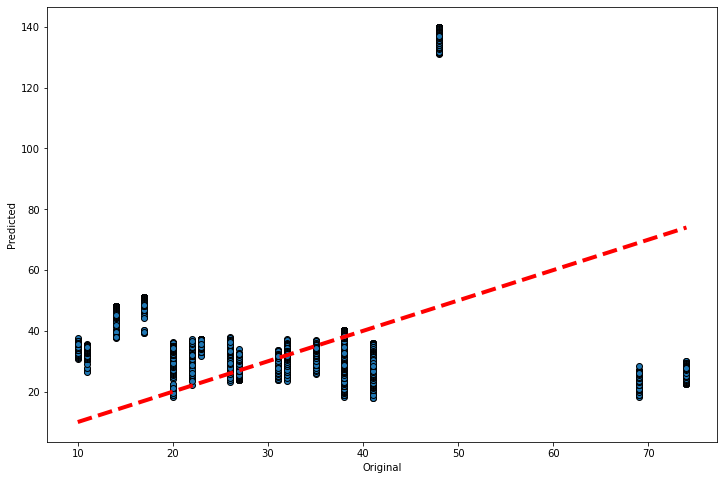

In [29]:
ridge = Ridge(alpha=6)

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(ridge, X, y, cv=5)

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

# K-Means Clustering
This part is not relevant, but I will leave it as an example of what could be done.

We start with 2 clusters only to setup the pipeline. This could be stressed / not stressed.

In [73]:
X = df_all[['stress_level', 'cortisol_before_sleep']]

kmeans = KMeans(n_clusters=2, random_state = 0)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Index(['stress_level', 'cortisol_before_sleep'], dtype='object')


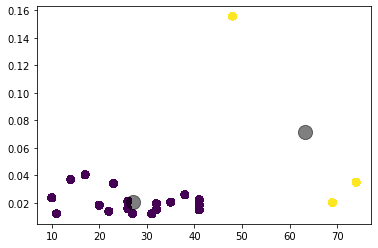

In [81]:
plt.scatter(X['stress_level'], X['cortisol_before_sleep'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

# Classification
We will train on the 20 first users and leave users 21, 22 and 23 for testing our algorithm.